In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import math
import random
import os
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

work_dir = 'Iyer_etal_2020_SFH_data/'
extn = '_sfhs_psds.mat'

simulation_names = ['Eagle', 'Illustris', 'IllustrisTNG', 'Mufasa', 'Simba', 'SC-Sam', 'UniverseMachine', 'Fire-2', 'Marvel_JL']
combined = []
for sim_name in simulation_names:
    sim_data = sio.loadmat(work_dir + sim_name + extn)

    # Interpolating SFHs into 139 timesteps 
    x = np.linspace(0, 14, 139) # creating general array to act as universal timestep array, with 139 timesteps
    sfhs = np.zeros((len(sim_data['smallsfhs'].T), 139)) # creating a np array of all 0s of size (number of galaxies, 139)
    xp = np.linspace(0, 14, len(sim_data['smallsfhs'].T[0])) 
    for i in range(len(sim_data['smallsfhs'].T)):
        sfhs[i] = np.interp(x, xp, sim_data['smallsfhs'].T[i])
        
    presentsfr = sfhs[:, -1]  # Accessing the last time step for redshift 0 sfr
    logmass = np.array(sim_data['logmass'].ravel())
    if sim_name in ['Simba', 'Mufasa']:
        combined = combined + [[arr, [m, np.arcsinh(s)]] for arr, m, s in zip(sfhs, logmass, presentsfr) if m > 10]
    else:
        combined = combined + [[arr, [m, np.arcsinh(s)]] for arr, m, s in zip(sfhs, logmass, presentsfr) if m > 9]
    # Setting a cut off for mass, categorized by simulation

In [2]:
inputHistories = np.array([element[0] for element in combined])
mass_presentsfr = np.array([element[1] for element in combined])

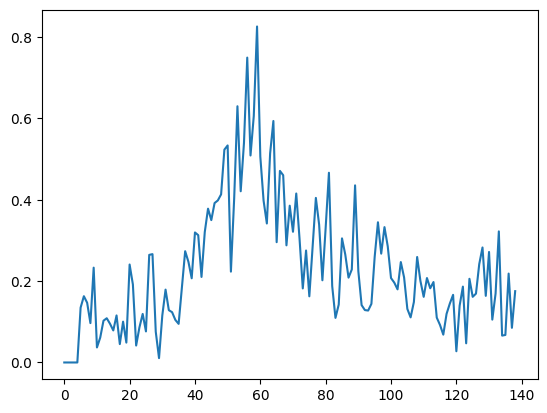

In [34]:
plt.plot(combined[0][0])

In [3]:
zero_indices = np.array([i for i in range(len(inputHistories)) if np.trapz(inputHistories[i]) == 0])

In [4]:
mask = np.ones(inputHistories.shape[0], dtype=bool)
mask[zero_indices] = False

filtered_inputHistories = inputHistories[mask]
filtered_mass_presentsfr = mass_presentsfr[mask]
# Removing SFHs that integrate to 0 and their corresponding mass/sfr data

In [5]:
X_train, X_test, y_train, y_test = train_test_split(filtered_inputHistories, filtered_mass_presentsfr, test_size=0.2, random_state=42)
# Split data first, then normalize
from sklearn.neural_network import MLPRegressor

In [6]:
X_train = [sfh / np.trapz(sfh) for sfh in X_train] # Normalize SFH
X_test = [sfh / np.trapz(sfh) for sfh in X_test] # Normalize SFH

In [7]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [23]:
regr = MLPRegressor(random_state=4,verbose=True, max_iter=500, 
                    hidden_layer_sizes=(200,200,200), learning_rate_init=0.001, learning_rate='adaptive')

In [24]:
regr.fit(X_train, y_train)

Iteration 1, loss = 1.91977874
Iteration 2, loss = 0.17825084
Iteration 3, loss = 0.17204182
Iteration 4, loss = 0.16970083
Iteration 5, loss = 0.16756577
Iteration 6, loss = 0.16518272
Iteration 7, loss = 0.16351499
Iteration 8, loss = 0.16260631
Iteration 9, loss = 0.16153394
Iteration 10, loss = 0.16033963
Iteration 11, loss = 0.15859650
Iteration 12, loss = 0.15801157
Iteration 13, loss = 0.15749376
Iteration 14, loss = 0.15668914
Iteration 15, loss = 0.15467970
Iteration 16, loss = 0.15458926
Iteration 17, loss = 0.15401590
Iteration 18, loss = 0.15237297
Iteration 19, loss = 0.15127778
Iteration 20, loss = 0.15069398
Iteration 21, loss = 0.14951793
Iteration 22, loss = 0.14861295
Iteration 23, loss = 0.14848045
Iteration 24, loss = 0.14650359
Iteration 25, loss = 0.14516811
Iteration 26, loss = 0.14423861
Iteration 27, loss = 0.14253033
Iteration 28, loss = 0.14214079
Iteration 29, loss = 0.14138108
Iteration 30, loss = 0.13945916
Iteration 31, loss = 0.14018416
Iteration 32, los

MLPRegressor(hidden_layer_sizes=(200, 200, 200), learning_rate='adaptive',
             max_iter=500, random_state=4, verbose=True)

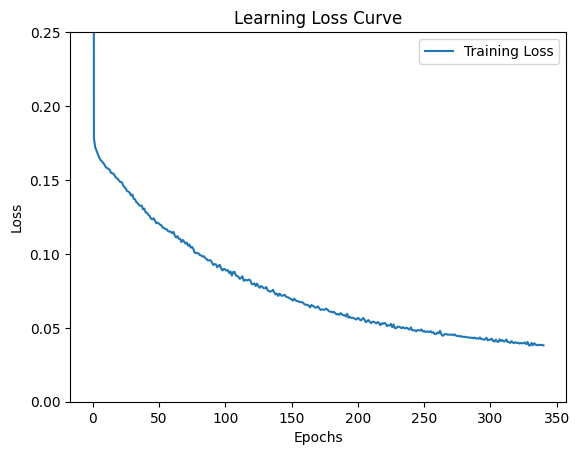

In [35]:
loss_curve = regr.loss_curve_
plt.plot(loss_curve, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,0.25)
plt.title('Learning Loss Curve')
plt.legend()
plt.show()

In [27]:
import pickle

# save
with open('0.03809model.pkl','wb') as f:
    pickle.dump(regr,f)

In [12]:
# load
with open('0.04957model.pkl', 'rb') as f:
    regr = pickle.load(f)
regr.score(X_test, y_test)

0.145830177061615

In [36]:
pred_mass = regr.predict(X_test).T[0]
pred_sfr = regr.predict(X_test).T[1]

stellar_mass = y_test.T[0]
star_formation_rate = y_test.T[1]

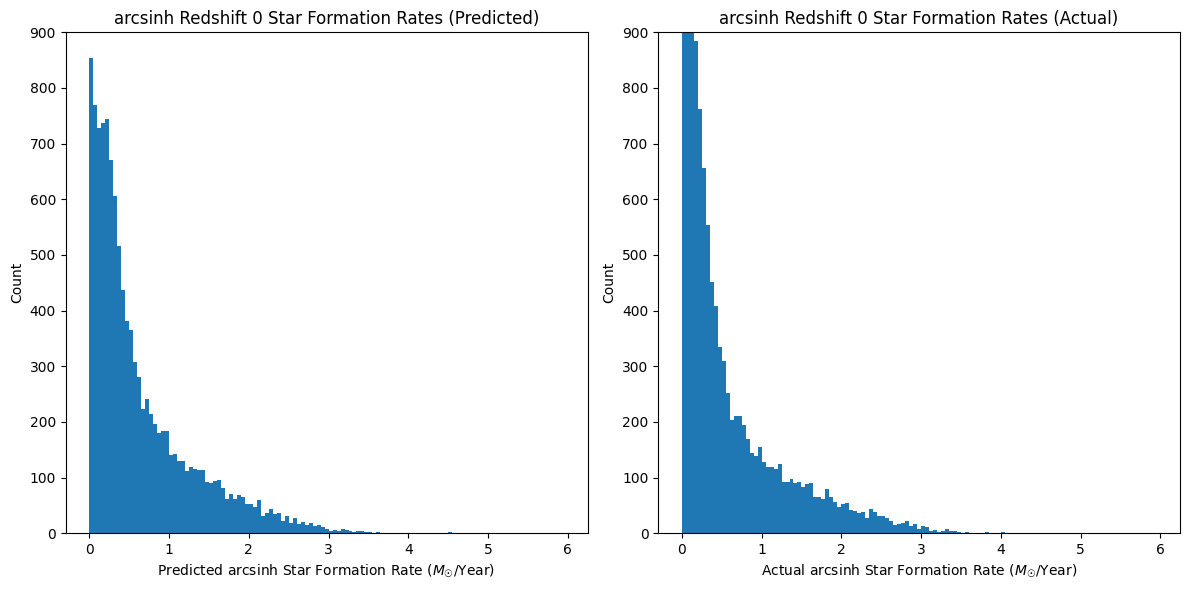

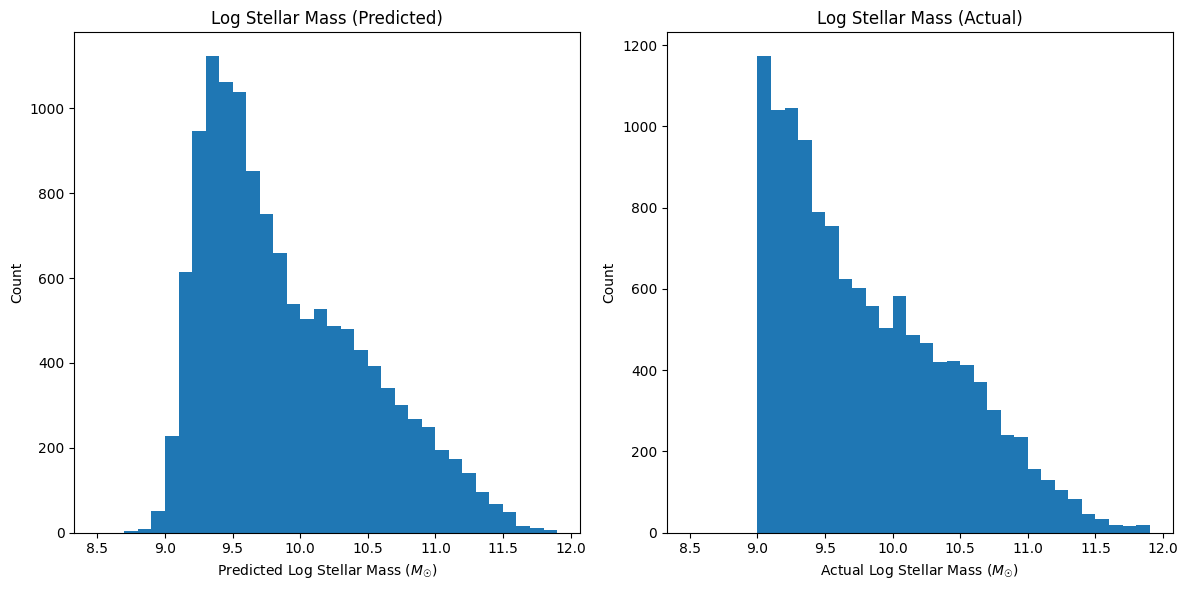

In [79]:
# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

hist = ax[0].hist(pred_sfr, bins=np.arange(0, 6, 0.05))
ax[0].set_xlabel('Predicted arcsinh Star Formation Rate ($M_\u2609$/Year)')
ax[0].set_ylabel('Count')
ax[0].set_ylim(0,900)
ax[0].set_title(f'arcsinh Redshift 0 Star Formation Rates (Predicted)')

hist = ax[1].hist(star_formation_rate, bins=np.arange(0, 6, 0.05))
ax[1].set_xlabel('Actual arcsinh Star Formation Rate ($M_\u2609$/Year)')
ax[1].set_ylabel('Count')
ax[1].set_ylim(0,900)
ax[1].set_title(f'arcsinh Redshift 0 Star Formation Rates (Actual)')

# Display the plots
plt.tight_layout()
plt.show()

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

hist = ax[0].hist(pred_mass, bins=np.arange(8.5, 12, 0.1))
ax[0].set_xlabel('Predicted Log Stellar Mass ($M_\u2609$)')
ax[0].set_ylabel('Count')
ax[0].set_title(f'Log Stellar Mass (Predicted)')

hist = ax[1].hist(stellar_mass, bins=np.arange(8.5, 12, 0.1))
ax[1].set_xlabel('Actual Log Stellar Mass ($M_\u2609$)')
ax[1].set_ylabel('Count')
ax[1].set_title(f'Log Stellar Mass (Actual)')
# Display the plots
plt.tight_layout()
plt.show()

In [39]:
np.percentile(pred_mass - stellar_mass,[1,5,10,50,90,95,99]) # Residual percentiles

array([-0.97870958, -0.52161799, -0.35043743,  0.07833777,  0.50301573,
        0.68542173,  1.07414967])

In [58]:
print(f'RMSE for Stellar Mass: {np.sqrt(np.mean((pred_mass - stellar_mass)**2))} \nRMSE for SFR: {np.sqrt(np.mean((pred_sfr - star_formation_rate)**2))}') #Root mean squared error

RMSE for Stellar Mass: 0.38187664285170936 
RMSE for SFR: 0.4500403081008377


In [41]:
np.percentile(pred_mass,[1,5,10,50,90,95,99]), np.sqrt(np.mean((pred_mass)**2)) 

(array([ 9.03734866,  9.16657559,  9.2401264 ,  9.74786661, 10.80741921,
        11.06750306, 11.44862723]),
 9.920757757910728)

In [42]:
np.percentile(np.sinh(pred_sfr) - np.sinh(star_formation_rate),[5,20,50,80,95])

array([-1.44135376, -0.16610179,  0.01192923,  0.28821602,  1.47228389])

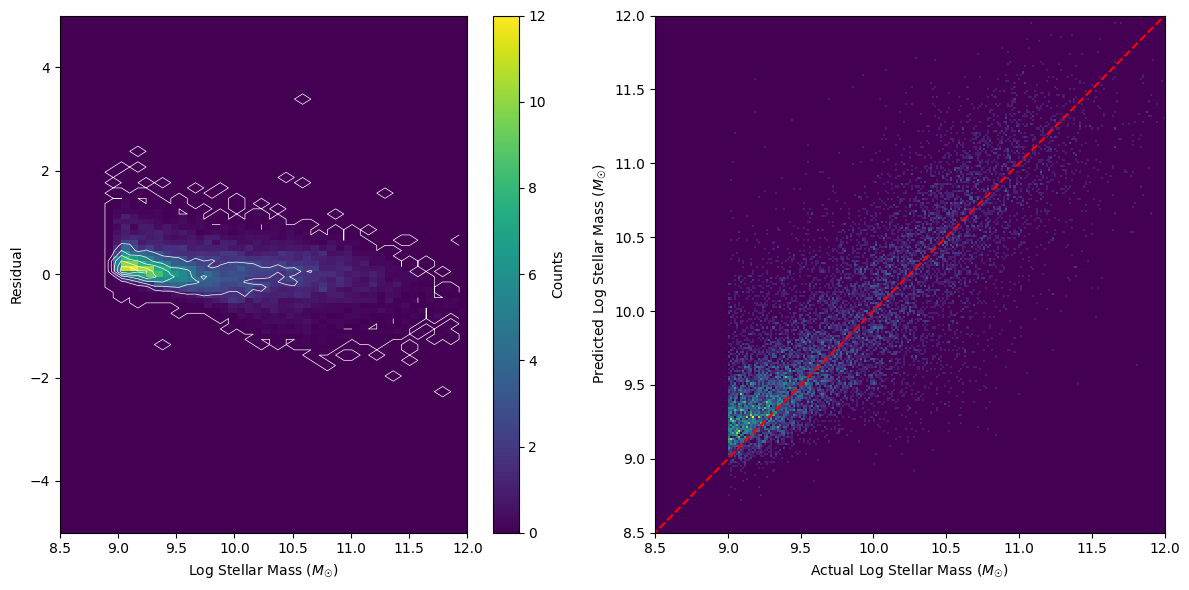

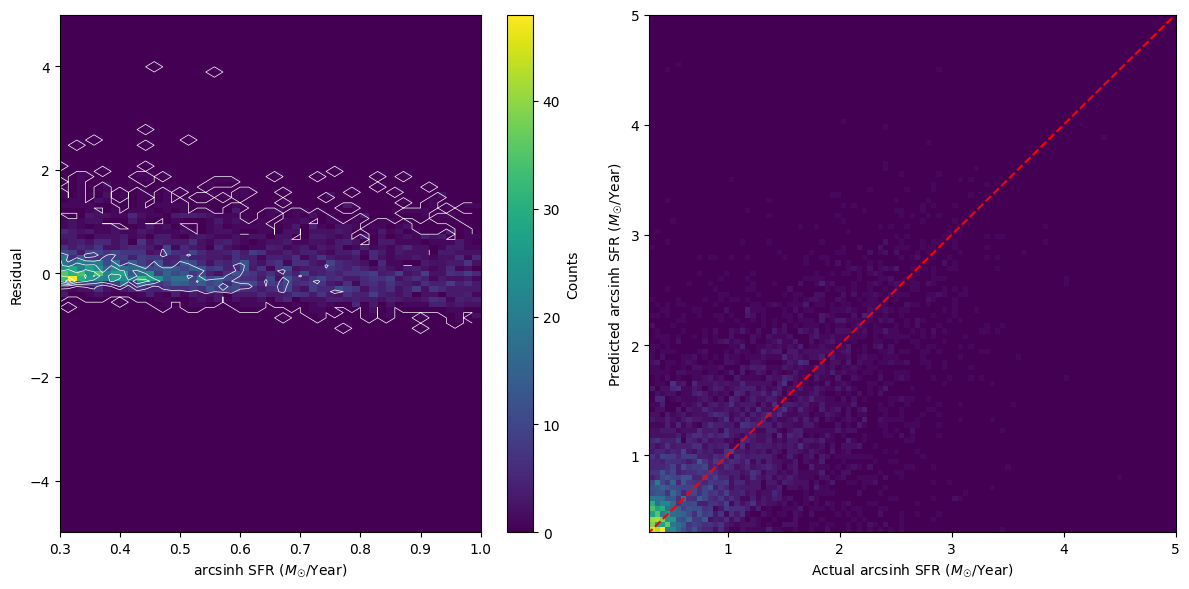

In [51]:
# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# First plot (2D Histogram of Stellar Mass vs Residuals)
hist = ax[0].hist2d(stellar_mass, pred_mass - stellar_mass, bins=[np.linspace(5, 12, 100), np.linspace(-5, 5, 100)])
ax[0].set_xlabel('Log Stellar Mass ($M_\u2609$)')
ax[0].set_ylabel('Residual')
ax[0].set_ylim(-5, 5)
ax[0].set_xlim(8.5, 12)

X, Y = np.meshgrid(np.linspace(5, 12, 100), np.linspace(-5, 5, 100))
ax[0].contour(X[:-1, :-1] + np.diff(X[:2, 0]) / 2.,
              Y[:-1, :-1] + np.diff(Y[0, :2]) / 2., hist[0].T, levels=6, colors='w', linewidths=0.5)

hist = ax[1].hist2d(stellar_mass, pred_mass, bins=[np.linspace(5, 12, 500), np.linspace(5, 12, 500)])
ax[1].set_xlabel('Actual Log Stellar Mass ($M_\u2609$)')
ax[1].set_ylabel('Predicted Log Stellar Mass ($M_\u2609$)')
ax[1].set_ylim(8.5, 12)
ax[1].set_xlim(8.5, 12)
ax[1].plot(x, x, color='red', linestyle='--', label='y=x')
cbar = plt.colorbar(hist[3], ax=ax[0])
cbar.set_label('Counts')


# Display the plots
plt.tight_layout()
plt.show()

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# First plot (2D Histogram of Stellar Mass vs Residuals)
hist = ax[0].hist2d(star_formation_rate, pred_sfr - star_formation_rate, bins=[np.linspace(0.3, 1, 50), np.linspace(-5, 5, 100)])
ax[0].set_xlabel('arcsinh SFR ($M_\u2609$/Year)')
ax[0].set_xlim(0.3,1)
ax[0].set_ylabel('Residual')

X, Y = np.meshgrid(np.linspace(0.3, 1, 50), np.linspace(-5, 5, 100))
ax[0].contour(X[:-1, :-1] + np.diff(X[:2, 0]) / 2.,
              Y[:-1, :-1] + np.diff(Y[0, :2]) / 2., hist[0].T, levels=6, colors='w', linewidths=0.5)

hist = ax[1].hist2d(star_formation_rate, pred_sfr, bins=[np.linspace(0.3, 5, 100), np.linspace(0.3, 5, 100)])
ax[1].set_xlabel('Actual arcsinh SFR ($M_\u2609$/Year)')
ax[1].set_ylabel('Predicted arcsinh SFR ($M_\u2609$/Year)')
ax[1].set_xlim(0.3,5)
ax[1].set_ylim(0.3,5)
ax[1].plot(x, x, color='red', linestyle='--', label='y=x')
cbar = plt.colorbar(hist[3], ax=ax[0])
cbar.set_label('Counts')


# Display the plots
plt.tight_layout()
plt.show()

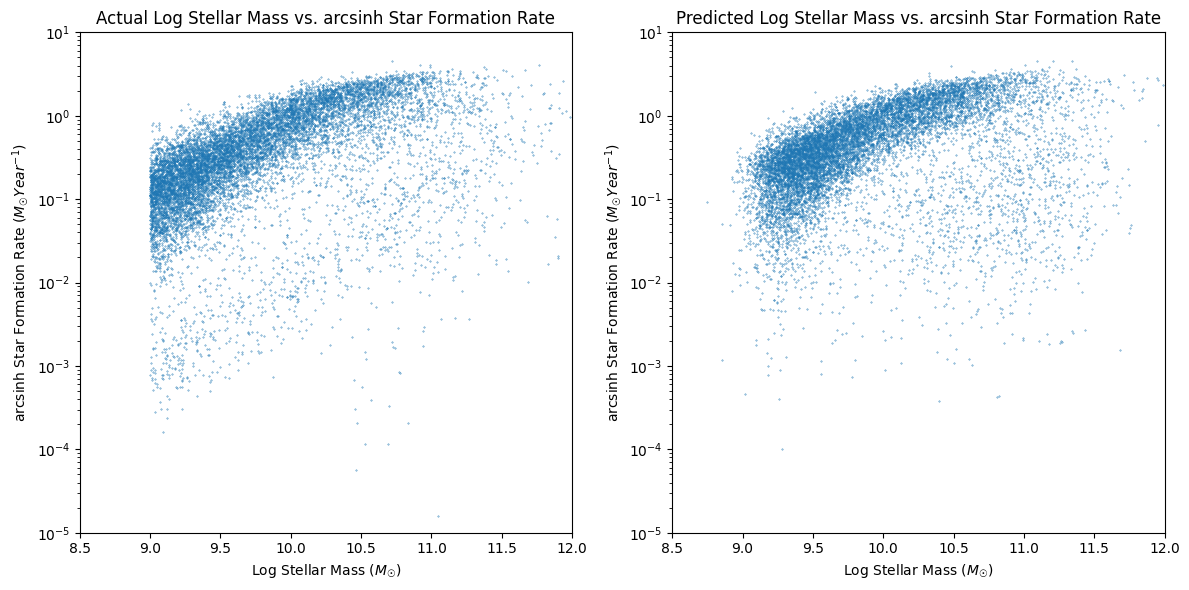

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# First plot (Actual Log Stellar Mass vs. arcsinh Star Formation Rate)
ax[0].scatter(stellar_mass, star_formation_rate, s=0.1, alpha=1)
ax[0].set_yscale('log')
ax[0].set_xlim(8.5, 12)
ax[0].set_ylim(1e-5, 10)
ax[0].set_xlabel('Log Stellar Mass ($M_\u2609$)')
ax[0].set_ylabel('arcsinh Star Formation Rate ($M_\u2609 Year^{-1}$)')
ax[0].set_title('Actual Log Stellar Mass vs. arcsinh Star Formation Rate')

# Second plot (Predicted Log Stellar Mass vs. arcsinh Star Formation Rate)
ax[1].scatter(pred_mass, pred_sfr, s=0.1, alpha=1)
ax[1].set_yscale('log')
ax[1].set_xlim(8.5, 12)
ax[1].set_ylim(1e-5, 10)
ax[1].set_xlabel('Log Stellar Mass ($M_\u2609$)')
ax[1].set_ylabel('arcsinh Star Formation Rate ($M_\u2609 Year^{-1}$)')
ax[1].set_title('Predicted Log Stellar Mass vs. arcsinh Star Formation Rate')

# Display the plots
plt.tight_layout()
plt.show()

In [64]:
for i in range(100):
    print(regr.predict([X_test[i]]), y_test[i])

[[9.51581726 0.19717856]] [9.61133358 0.29440867]
[[9.25921497 0.19928544]] [9.11070908 0.15931837]
[[9.4034068 0.0730263]] [9.0414659  0.00953458]
[[9.66554948 0.25452358]] [9.09819625 0.06967196]
[[ 9.92563074 -0.13242739]] [10.04281802  0.        ]
[[9.49947851 0.24622293]] [9.68509459 0.37986266]
[[9.86328648 0.46164713]] [9.62423962 0.09008146]
[[9.62322147 0.56437369]] [9.11774704 0.18507486]
[[10.35115575  1.03925317]] [10.26141174  1.02102895]
[[ 9.69127754 -0.08529851]] [10.83707445  0.        ]
[[9.37185504 0.14777623]] [9.03770658 0.08666939]
[[10.63022213  0.8156221 ]] [10.44657663  0.87878608]
[[9.17381835 0.16040862]] [9.10257531 0.16816911]
[[9.25147858 0.23004936]] [9.30918403 0.26263102]
[[10.69729182  2.34972191]] [10.44062037  1.70305033]
[[10.90842209 -0.06289178]] [11.16130348  0.13687805]
[[9.25585955 0.16051344]] [9.14976066 0.15511817]
[[9.3297125  0.08385352]] [9.09305153 0.03956648]
[[9.03606874 0.07231287]] [9.00502396 0.10715248]
[[9.48615061 0.44009247]] [9

In [21]:
# testing_loss_logmass = []
# testing_loss_sfr = []

# for i in range(100):
#     regr.fit(X_train, y_train)
    
#     predictions = regr.predict(X_test).T
#     actuals = y_test.T
    
#     log_mass_loss = sum((predictions[0] - actuals[0]) ** 2)
#     sfr_loss = sum((predictions[1] - actuals[1]) ** 2)
    
#     testing_loss_logmass.append(log_mass_loss)
#     testing_loss_sfr.append(sfr_loss)
#     print(log_mass_loss, sfr_loss, predictions)

# plt.figure(figsize=(10, 6))
# plt.plot(testing_loss_logmass, label='Log Mass Training Loss')
# plt.plot(testing_loss_sfr, label='Present SFR Training Loss')
# plt.xlabel('Iteration')
# plt.ylabel('Log Loss')
# plt.title('Training Curve')
# plt.legend()
# plt.show()

In [22]:
testing_loss_logmass

NameError: name 'testing_loss_logmass' is not defined

In [ ]:
plt.plot(regr.loss_curve_, label='Training Loss')
plt.show

In [ ]:
# Data cleaning: resolution limits should necessitate cut off
# everything M > 10^9, s&m M > 10^10